<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Sensitivity Curve Plot</h1>
    <p style="text-align:center;">This notebook demonstrates how to reproduce the plot of the detectable sources on the LISA sensitivity curve.</p>
</div>

In [1]:
# general package imports
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns

from matplotlib.colors import Normalize as Norm

import time

# custom LISA package
import legwork

# import code from repo
import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw
from seaborn_utility import cmap_from_colour
from verification_binaries import verification_binaries

from bootstrap import bootstrapped_kde, bootstrapped_ecdf
import uncertainties as unc

In [2]:
# config stuff to make plots look pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [3]:
# define what DCOs we are working with and a colour scheme
dco_types = ["BHBH", "BHNS", "NSNS"]
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

# IMPORTANT: these need to point to the folders where you stored the data from Zenodo
data_folder = "../../simulation/data/"
sim_folder = data_folder + "simulation_high_res_double/"

# load a bunch of data
total_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW_nohubble.npy")
detections_4yr = np.load(data_folder + "detections_4yr.npy")
detections_10yr = np.load(data_folder + "detections_10yr.npy")

# Create LEGWORK sources and calculate SNRs

In [4]:
fid_sources = [None, None, None]
for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        
        data = full_data[snr_mask]
        
    fid_sources[i] = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                dist=data["dist"] * u.kpc, ecc=data["e_LISA"],
                                                a=data["a_LISA"] * u.AU)
    fid_sources[i].weight = data["weight"]

In [5]:
for i in range(len(dco_types)):
    fid_sources[i].get_snr(verbose=True)

Calculating SNR for 46424 sources
	46421 sources are stationary
		30416 sources are stationary and circular
		16005 sources are stationary and eccentric
	3 sources are evolving
		3 sources are evolving and circular
Calculating SNR for 44927 sources
	44925 sources are stationary
		41843 sources are stationary and circular
		3082 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular
Calculating SNR for 32805 sources
	32803 sources are stationary
		18591 sources are stationary and circular
		14212 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular


# Density Distribution

First we define a function that plots the sensitivity curve with some grid lines and then plot the density distribution.

In [7]:
def plot_sc_with_grid_lines(frequency_range, fig, ax, mc_mean, mc_min, line_scale=1, line_rot=10, loc=-75):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=ax)
    
    times = np.logspace(0, -8, 9) * u.Gyr
    athings = np.power(4 * legwork.utils.beta(mc_min * 2**(1/5), mc_min * 2**(1/5)) * times, 1/4)
    freqs = legwork.utils.get_f_orb_from_a(a=athings, m_1=mc_min * 2**(1/5), m_2=mc_min * 2**(1/5))
    hide_height = np.sqrt(legwork.psd.lisa_psd(freqs))
    
    for i in range(len(times)):
        ax.plot([freqs[i].value, freqs[i].value], [hide_height[i].value, 1e-13],
                color="grey", lw=line_scale, zorder=0, linestyle="dotted")
        ax.annotate(r"$10^{{{0:1.0f}}}$ yr".format(np.log10(times[i].to(u.yr).value)), xy=(freqs[i].value, 7.5e-14),
                    va="top", ha="center", rotation=90, fontsize=10 * line_scale, color="grey",
                    bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(mc_mean, line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        ax.plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0, lw=line_scale)
        ax.annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * (0.45 + line_scale / 20)), xycoords="data", color="grey", rotation=line_rot * 1.2, 
                         ha="right", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    e_dist_line = 0.98
    nmax = 1500
    e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                      ecc=np.repeat(e_dist_line, line_length),
                                      f_orb=lines_f_range,
                                      m_1=np.repeat(mc_min * 2**(1/5), line_length),
                                      m_2=np.repeat(mc_min * 2**(1/5), line_length))
    e_sources.get_snr()
    dominant_freq = lines_f_range * e_sources.max_snr_harmonic
    e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
    check = np.argmin(np.diff(dominant_freq))
    mask = e_sources.snr[:check] > 1
    ax.plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=line_scale, zorder=0, color="grey", linestyle="dotted")

    ax.annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][loc].value, e_dist_line_signal[:check][mask][loc].value), xycoords="data", color="grey",
                     rotation=line_rot * 1.1, ha="center", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    ax.annotate(r"$\langle \mathcal{{M}}_c \rangle = {{{0:1.1f}}} \, M_{{\odot}}$".format(mc_mean.value), xy=(1e-2, 3e-20), ha="center", va="center", 
                fontsize=12 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    return fig, ax

full done
BHBH done
BHNS done
NSNS done


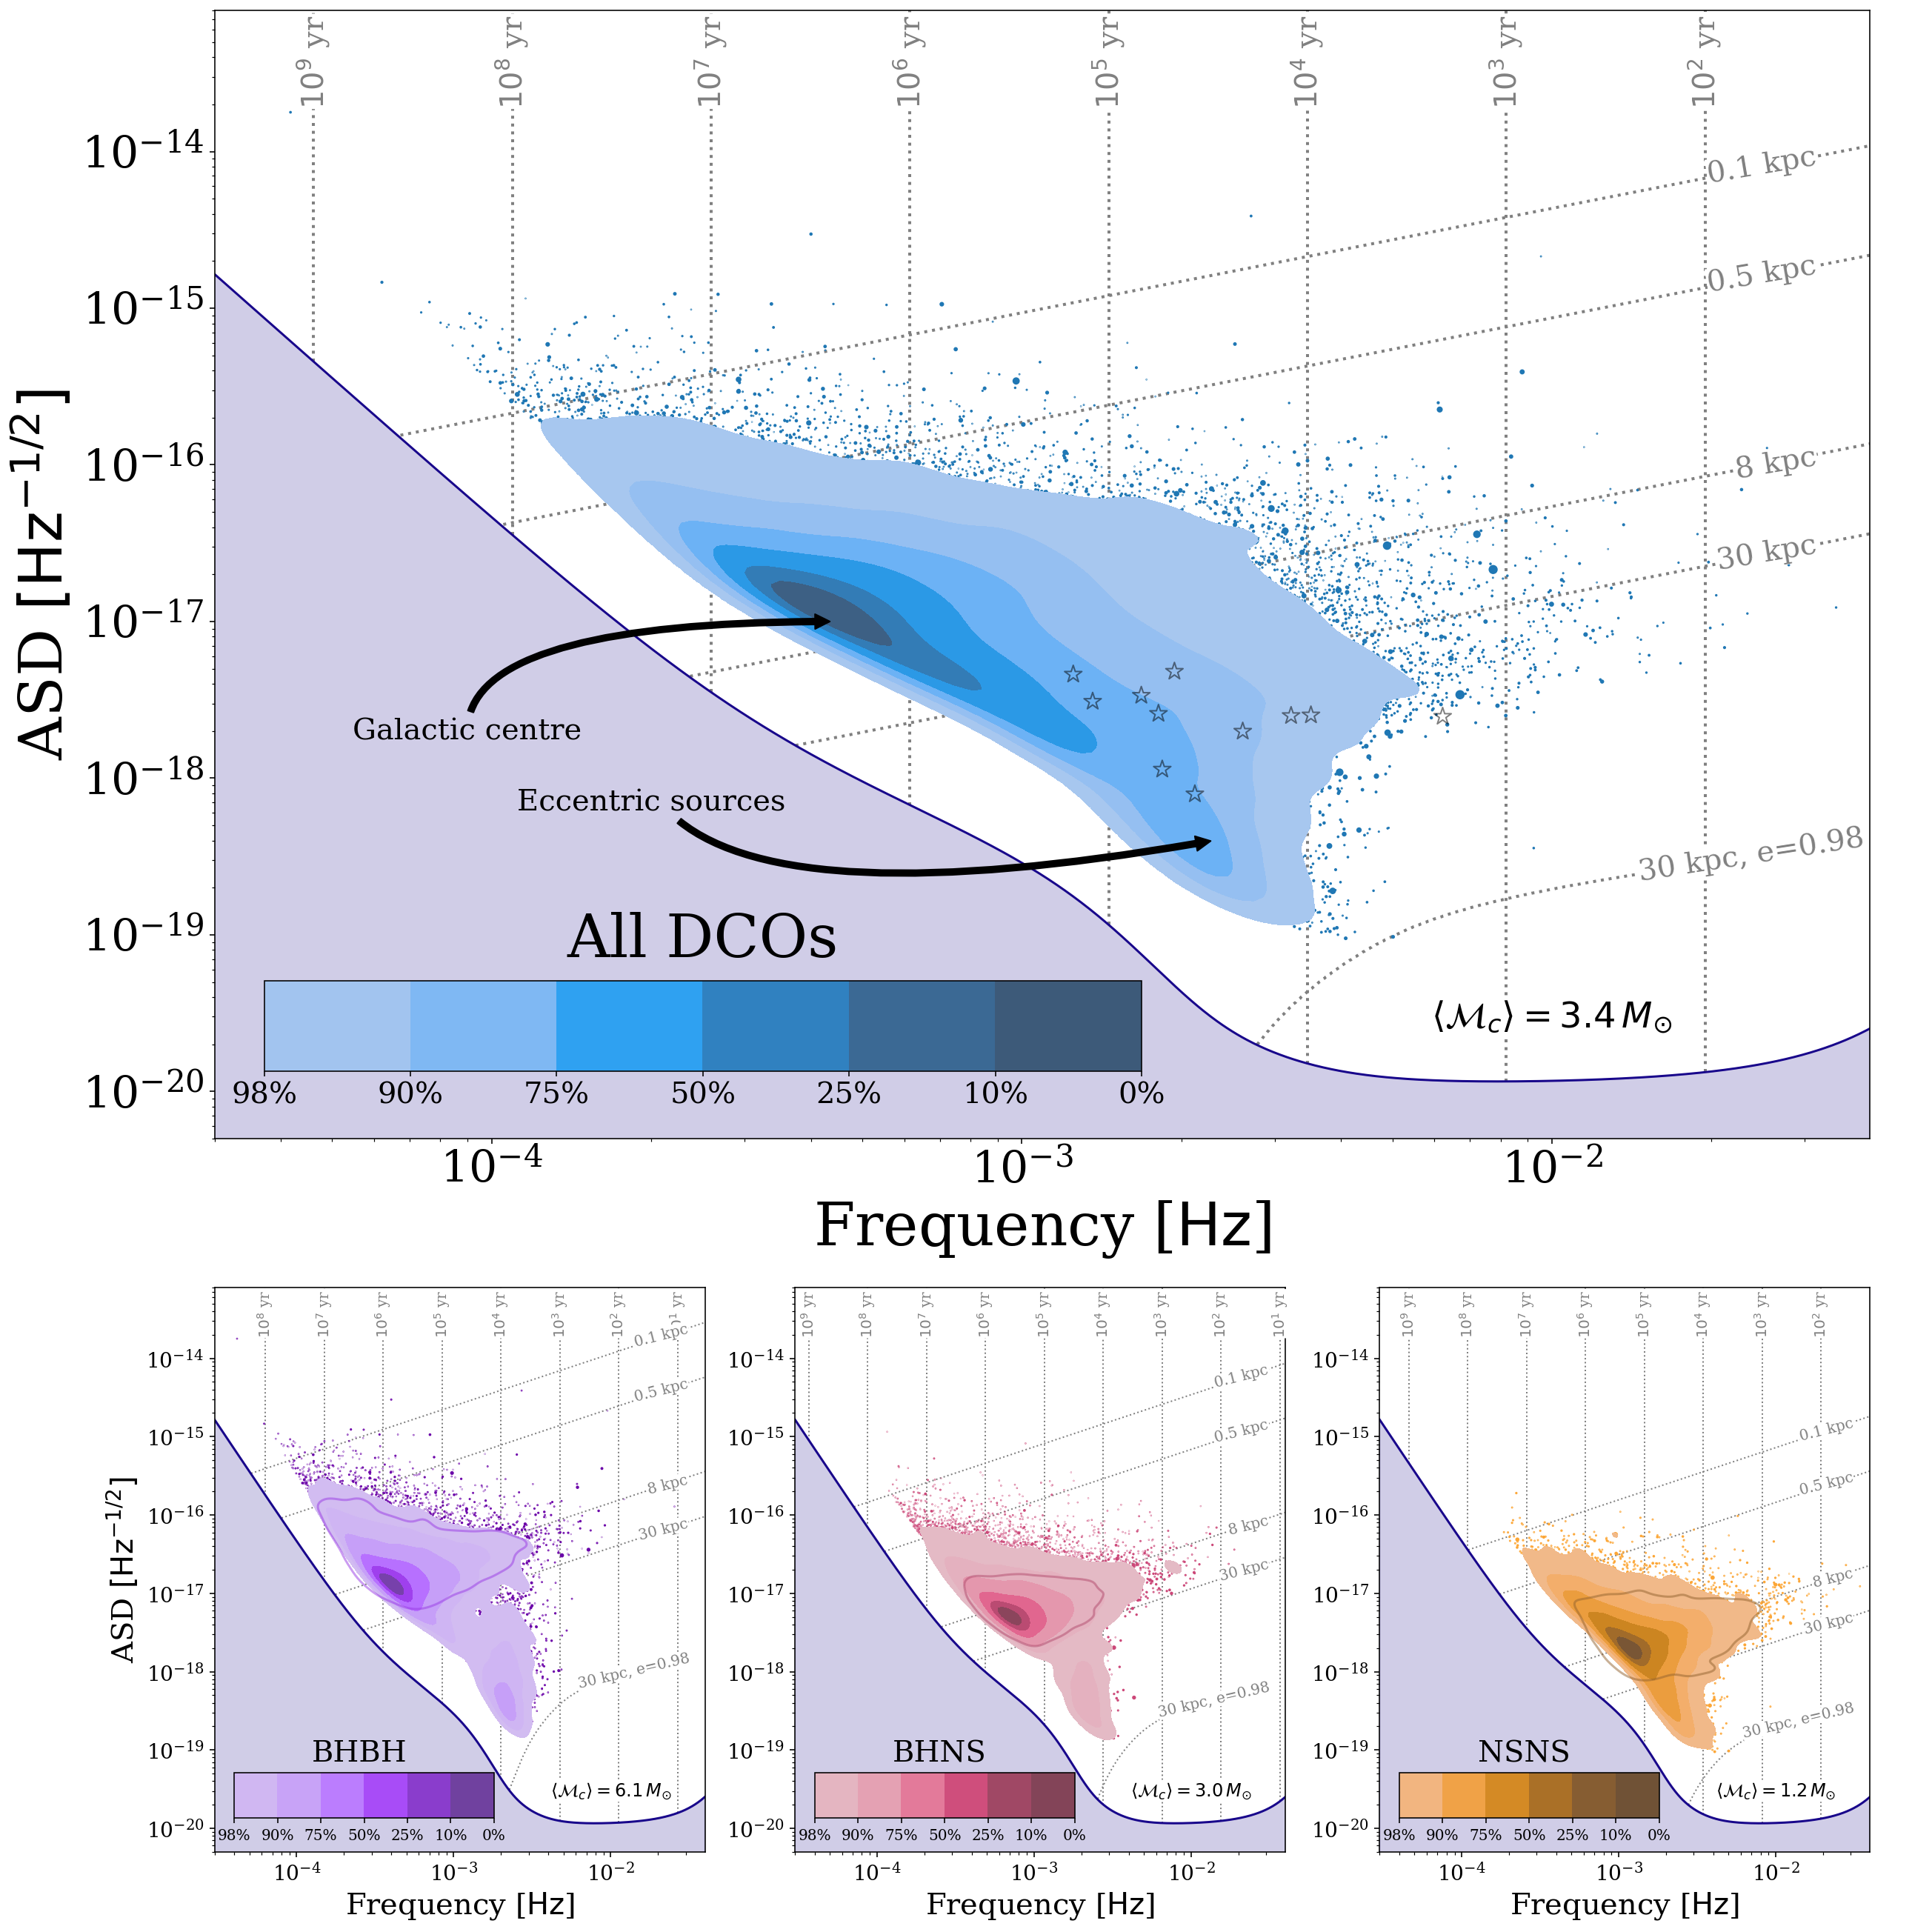

In [9]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig = plt.figure(figsize=(18, 18), constrained_layout=True)

gs = GridSpec(2, 3, figure=fig, height_ratios=(2, 1))
all_ax = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[1, i]) for i in range(3)]
levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
level_labels = ["98%", "90%", "75%", "50%", "25%", "10%", "0%"]

all_mc_mean = np.mean([fid_sources[i].m_c.mean().value for i in range(len(fid_sources))]) * u.Msun
all_mc_min = np.min([fid_sources[i].m_c.min().value for i in range(len(fid_sources))]) * u.Msun
fig, all_ax = plot_sc_with_grid_lines(frequency_range, fig=fig, ax=all_ax,
                                      mc_mean=all_mc_mean,
                                      mc_min=all_mc_min,
                                      line_scale=2, line_rot=8, loc=-10)

all_f_dom = np.concatenate([fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic for i in range(len(fid_sources))])
all_snr = np.concatenate([fid_sources[i].snr for i in range(len(fid_sources))])
all_weight = np.concatenate([fid_sources[i].weight for i in range(len(fid_sources))])
all_ecc = np.concatenate([fid_sources[i].ecc for i in range(len(fid_sources))])

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", s=all_weight * 25)

all_ax.annotate("Galactic centre",
                xy=(4.4e-4, 1e-17), xycoords='data',
                xytext=(9e-5, 2e-18), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=90,angleB=0"),
                fontsize=fs, ha="center", va="center")

all_ax.annotate("Eccentric sources",
                xy=(2.3e-3, 4e-19), xycoords='data',
                xytext=(2e-4, 7e-19), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=120,angleB=10", relpos=(0.5, 1.0)),
                fontsize=fs, ha="center", va="center")

f_GWs = [vb["f_GW"].to(u.Hz).value for vb in verification_binaries if vb["snr"] > 7]
ASDs = [(legwork.psd.lisa_psd(vb["f_GW"])**(0.5) * vb["snr"]).to(u.Hz**(-1/2)).value for vb in verification_binaries if vb["snr"] > 7]
all_ax.scatter(f_GWs, ASDs, s=150, facecolor="none", edgecolor="black", marker="*", alpha=0.5,
               label="Verification binaries", zorder=10)

# the lazy man's guide to colorbars: just plot hidden points
cmap = cmap_from_colour("tab:blue")
scatter = all_ax.scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
inset_all_ax = all_ax.inset_axes([0.03, 0.06, 0.53, 0.08])
cbar = fig.colorbar(scatter, ax=all_ax, cax=inset_all_ax, boundaries=levels, orientation="horizontal")
cbar.set_ticklabels(level_labels)
cbar.ax.tick_params(labelsize=fs)

all_ax.annotate("All DCOs", xy=(0.295, 0.15), xycoords="axes fraction", fontsize=2 * fs, color="black", ha="center", va="bottom")

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", weights=all_weight,
                                                  disttype="kde", fill=True, levels=levels)

print("full done")

for i, dco_type in enumerate(dco_types):
    fig, axes[i] = plot_sc_with_grid_lines(frequency_range, fig=fig, ax=axes[i],
                                           mc_mean=fid_sources[i].m_c.mean(),
                                           mc_min=fid_sources[i].m_c.min(), line_rot=12, loc=-105)
    
    # the lazy man's guide to colorbars: just plot hidden points
    cmap = cmap_from_colour(dco_colours[dco_types[i]])
    scatter = axes[i].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = axes[i].inset_axes([0.04, 0.06, 0.53, 0.08])
    cbar = fig.colorbar(scatter, ax=axes[i], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(level_labels)
    cbar.ax.tick_params(labelsize=10)
    
    f_dom = fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], s=fid_sources[i].weight / fid_sources[i].weight.sum() * 1e4)
    
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], weights=fid_sources[i].weight,
                                                      disttype="kde", fill=True, levels=levels,
                                                      bw_adjust=0.8 if i == 0 else 1.0 if i == 1 else 0.9)
    
    mask = fid_sources[i].ecc < 0.01
    color = list(cmap(0.75))
    color[-1] = 0.5
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom[mask], snr=fid_sources[i].snr[mask],
                                                      fig=fig, ax=axes[i], show=False, color=tuple(color),
                                                      weights=fid_sources[i].weight[mask], disttype="kde",
                                                      fill=False, levels=[0.1],
                                                      bw_adjust=0.8 if i == 0 else 1.0 if i == 1 else 0.9)

    axes[i].annotate(dco_types[i], xy=(0.295, 0.15), xycoords="axes fraction",
                     fontsize=fs, color="black", ha="center", va="bottom")
    
    print(dco_types[i], "done")

ylims = (5e-21, 8e-14)
    
for ax in [all_ax] + axes:
    if ax in axes[1:]:
        ax.set_ylabel("")
    ax.set_ylim(ylims)
    
all_ax.tick_params(labelsize=1.5 * fs)
all_ax.xaxis.label.set_fontsize(2 * fs)
all_ax.yaxis.label.set_fontsize(2 * fs)

# plt.savefig("../figures/dcos_on_sc.png", dpi=300, bbox_inches="tight")
# plt.savefig("../figures/dcos_on_sc_high_res.png", dpi=600, bbox_inches="tight")

# plt.savefig("../figures/dcos_on_sc_alt.png", dpi=300, bbox_inches="tight")
# plt.savefig("../figures/dcos_on_sc_high_res_alt.png", dpi=600, bbox_inches="tight")

plt.show()

## Scatter plot with eccentricity

This plot is used in the appendix to demonstrate how the eccentric sources are located in a different place.

BHBH done
BHNS done
NSNS done


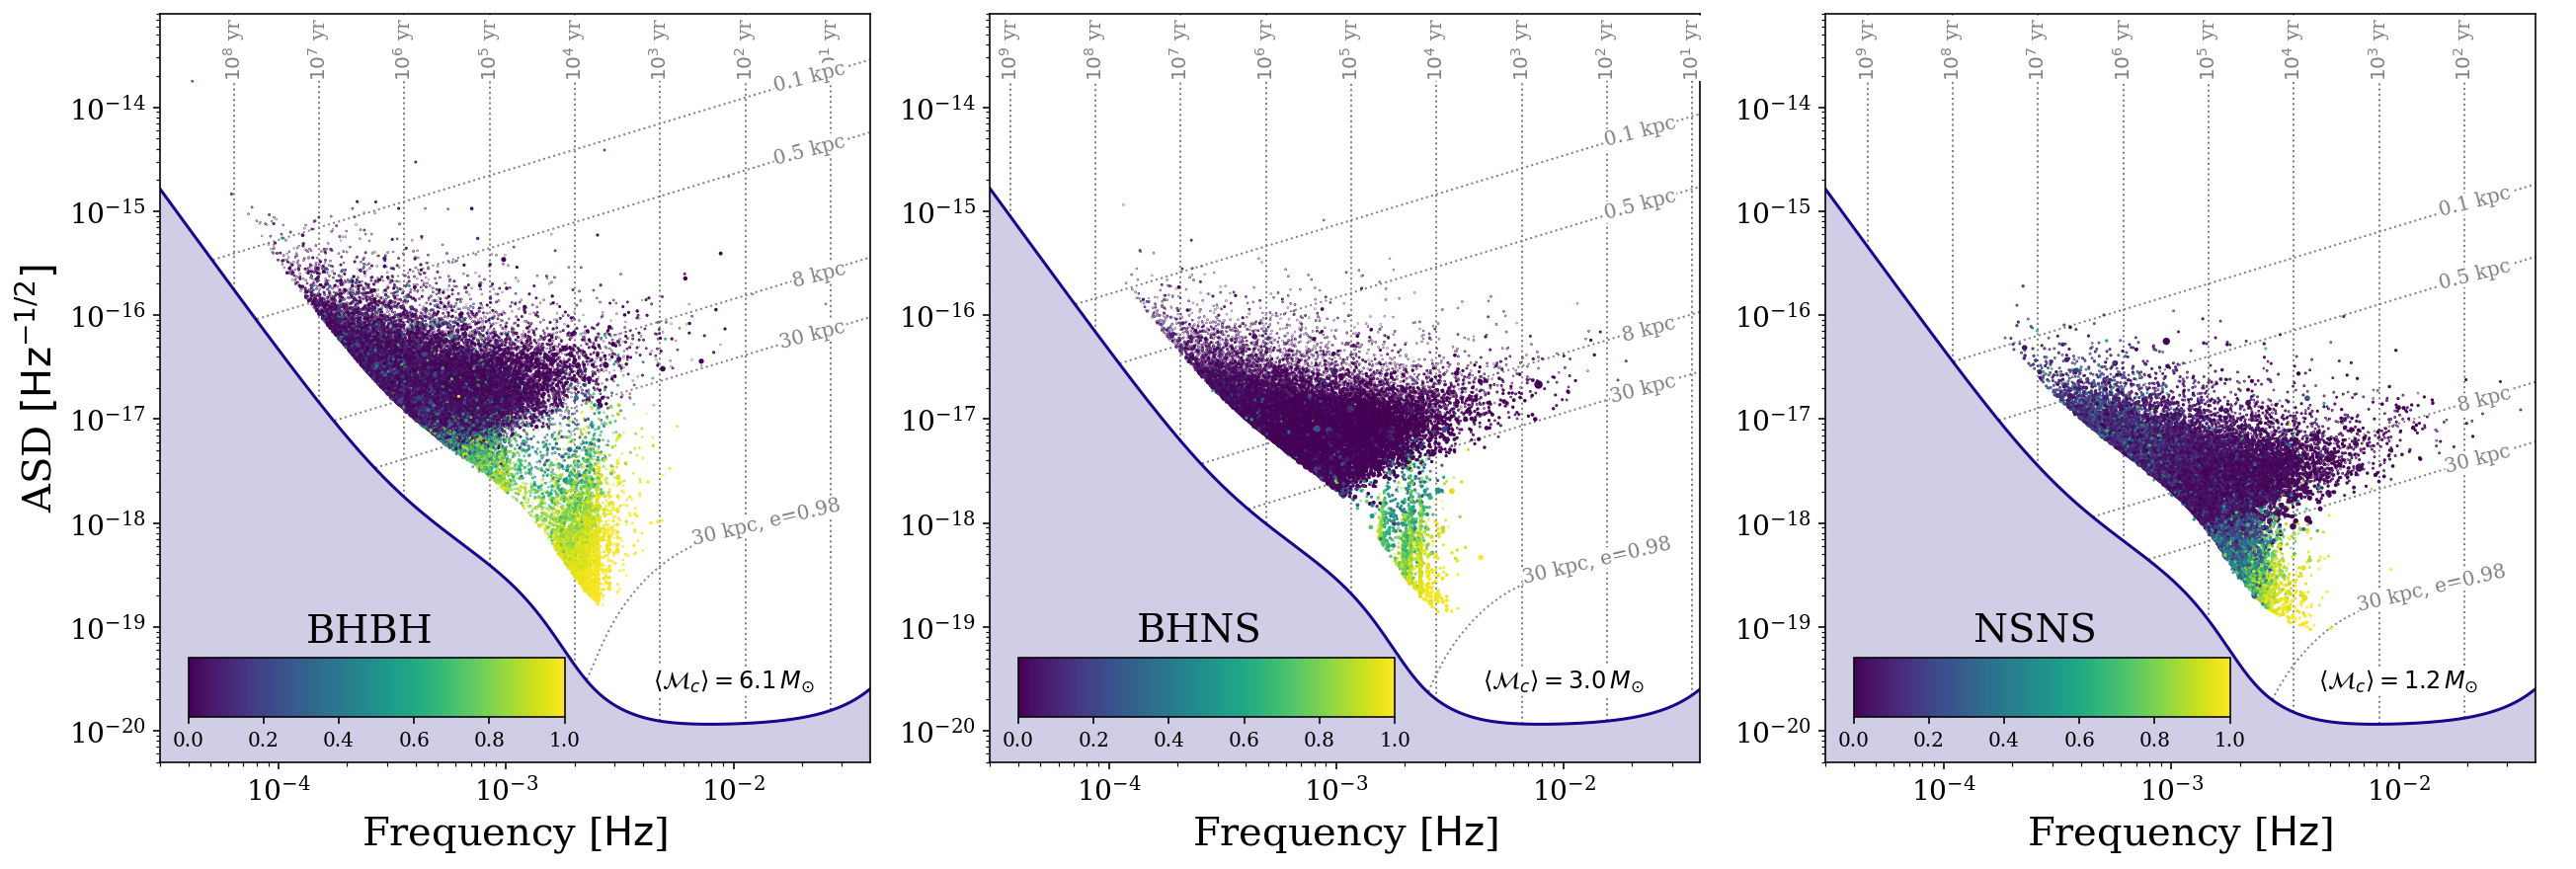

In [15]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for i, dco_type in enumerate(dco_types):
    fig, axes[i] = plot_sc_with_grid_lines(frequency_range, fig=fig, ax=axes[i],
                                           mc_mean=fid_sources[i].m_c.mean(),
                                           mc_min=fid_sources[i].m_c.min(), line_rot=12, loc=-105)
    
    f_dom = fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic
    scatter = legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      c=fid_sources[i].ecc, cmap="viridis",
                                                      s=fid_sources[i].weight / fid_sources[i].weight.sum() * 1e4, norm=Norm(vmin=0.0, vmax=1.0))
    
    inset_ax = axes[i].inset_axes([0.04, 0.06, 0.53, 0.08])
    cbar = fig.colorbar(axes[i].collections[-1], ax=axes[i], cax=inset_ax, orientation="horizontal")
    cbar.ax.tick_params(labelsize=10)

    axes[i].annotate(dco_types[i], xy=(0.295, 0.15), xycoords="axes fraction",
                     fontsize=fs, color="black", ha="center", va="bottom")
    
    print(dco_types[i], "done")

ylims = (5e-21, 8e-14)
    
for ax in axes:
    if ax in axes[1:]:
        ax.set_ylabel("")
    ax.set_ylim(ylims)

plt.savefig("../figures/dcos_on_sc_eccentric_colours.png", dpi=300, bbox_inches="tight")

plt.show()